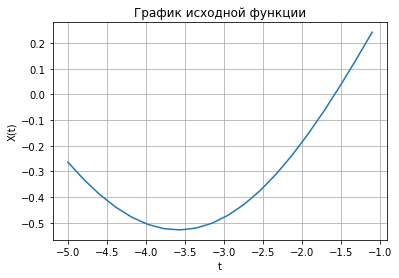

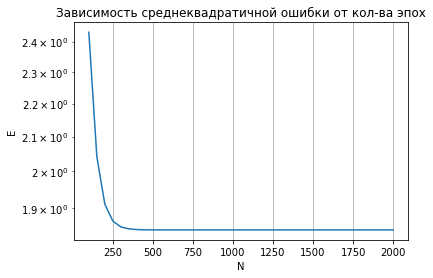

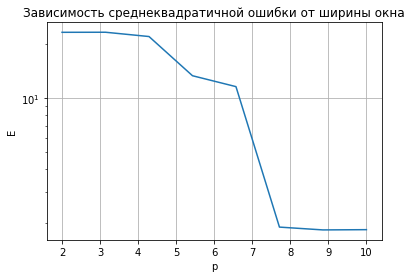

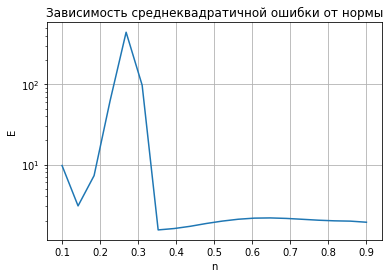

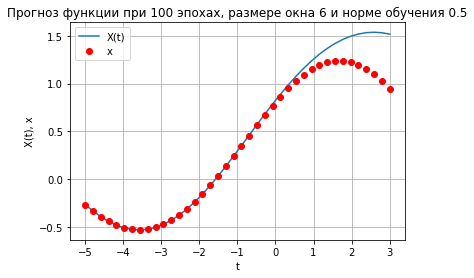

KeyboardInterrupt: 

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

class Model(object):
    
    def __init__(self, window_width):
        self.window_width = window_width
        self.w = np.zeros(self.window_width)
        self.w0 = 0
        self.x0 = 1
        self.initial_interval = np.zeros(0)
    
    def calculate(self, calculate_interval, norm, epochs):
        self.initial_interval = calculate_interval
        X = np.zeros(len(calculate_interval))
        for i in range(self.window_width):
            X[i] = calculate_interval[i]
        epochs_for_stats = epochs
        while epochs != 0:
            X_temp = X.copy()
            eps = 0
            for i in range(len(calculate_interval) - self.window_width):
                window = X_temp[i:i + self.window_width].copy()                
                for j in range(self.window_width):
                    X_temp[i + self.window_width] += self.w[j]*window[j]
                X_temp[i + self.window_width] += self.w0*self.x0
                delta = calculate_interval[i + self.window_width] - X_temp[i + self.window_width]
                eps += math.sqrt(pow(calculate_interval[i + self.window_width] - X_temp[i + self.window_width],2))
                for k in range(self.window_width):
                    self.w[k] = self.w[k] + norm*delta*window[k]
                self.w0 = self.w0 + norm*delta*self.x0        
            epochs -= 1
        return eps

    def predict(self, predict_interval_len):

        predict_interval = np.zeros(predict_interval_len)
        full_interval = np.concatenate((self.initial_interval, predict_interval), axis=None)
        for i in range(predict_interval_len):
            window = full_interval[i + len(self.initial_interval) - self.window_width:i + len(self.initial_interval)]
            for j in range(self.window_width):
                full_interval[i + len(self.initial_interval)] += self.w[j]*window[j]
            full_interval[i + len(self.initial_interval)] += self.w0*self.x0       
        return full_interval

def x(t):
    return 0.5*math.exp(0.5*math.cos(0.5*t))+math.sin(0.5*t)

def create_ab_interval_y(ab_interval_x):

    ab_interval_y = np.zeros(len(ab_interval_x))
    for i in range(len(ab_interval_x)):
        t = ab_interval_x[i]
        ab_interval_y[i] = x(t)
    return ab_interval_y

def RMSD(real_interval, predicted_interval):

    eps = 0
    for i in range(len(real_interval)):
        eps += math.sqrt(pow(real_interval[i] - predicted_interval[i],2))
    return eps

def define_best_params(ab_interval_x_real, ab_interval_y_real):
    epoch_nums = np.linspace(4050, 6850, num=8)
    window_widths = np.linspace(4, 11, num=8)
    norms = np.linspace(0.15, 0.36, num=8)
    errors = np.zeros(0)

    for i in range(len(window_widths)):
        for j in range(len(norms)):
            for k in range(len(epoch_nums)):
                model = Model(window_width=int(window_widths[i]))
                model.calculate(calculate_interval=ab_interval_y_real[:20], norm=norms[j], epochs=epoch_nums[k])
                prediction = model.predict(predict_interval_len=20)
                err = RMSD(ab_interval_y_real[20:], prediction[20:])
                errors = np.append(errors, err)
                if err <= min(errors):
                    min_error = err
                    min_i = i
                    min_j = j
                    min_k = k

    print("\nМинимально возможная ошибка:", min_error, ". Соответствующие ей параметры модели:", " Кол-во эпох:", epoch_nums[min_k], "| Ширина окна:", window_widths[min_i], "| Норма обучения:", norms[min_j])

    model1 = Model(window_width=int(window_widths[min_i]))
    model1.calculate(calculate_interval=ab_interval_y_real[:20], norm=norms[min_j], epochs=epoch_nums[min_k])
    prediction1 = model1.predict(predict_interval_len=20)
    plt.plot(ab_interval_x_real, ab_interval_y_real, label='X(t)')
    plt.plot(ab_interval_x_real, prediction1, 'ro', label='x')
    plt.title("Исходная функция и её прогноз при " + str(epoch_nums[min_k]) + " эпохах, размере окна " + str(window_widths[min_i]) + " и норма обучения " + str(norms[min_j]))
    plt.xlabel("t")
    plt.ylabel("X(t), x")
    plt.legend()
    plt.grid()
    plt.show()

def main():

    ab_interval_x_real = np.linspace(-5, 3, num=40)
    ab_interval_y_real = create_ab_interval_y(ab_interval_x_real)
    plt.title("График исходной функции")
    plt.xlabel("t")
    plt.ylabel("X(t)")
    plt.grid()
    plt.plot(ab_interval_x_real[:20], ab_interval_y_real[:20])
    plt.show()
    epoch_nums = np.linspace(100, 2000, num=39)
    errors = []
    for i in range(len(epoch_nums)):
        model = Model(window_width=10)
        model.calculate(calculate_interval=ab_interval_y_real[:20], norm=0.5, epochs=epoch_nums[i])
        errors.append(RMSD(ab_interval_y_real[20:], model.predict(20)[20:]))
    plt.title("Зависимость среднеквадратичной ошибки от кол-ва эпох")
    plt.xlabel("N")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(epoch_nums, errors)
    plt.show()   
    window_widths = np.linspace(2, 10, num=8)
    errors = []
    for i in range(len(window_widths)):
        model = Model(window_width=int(window_widths[i]))
        model.calculate(calculate_interval=ab_interval_y_real[:20], norm=0.5, epochs=1000)
        errors.append(RMSD(ab_interval_y_real[20:], model.predict(20)[20:]))
    plt.title("Зависимость среднеквадратичной ошибки от ширины окна")
    plt.xlabel("p")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(window_widths, errors)
    plt.show()

    norms = np.linspace(0.1, 0.9, num=20)
    errors = []
    for i in range(len(norms)):
        model = Model(window_width=7)
        model.calculate(calculate_interval=ab_interval_y_real[:20], norm=norms[i], epochs=1000)
        errors.append(RMSD(ab_interval_y_real[20:], model.predict(20)[20:]))
    plt.title("Зависимость среднеквадратичной ошибки от нормы")
    plt.xlabel("n")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(norms, errors)
    plt.show()

    model2 = Model(window_width=int(6))
    model2.calculate(calculate_interval=ab_interval_y_real[:20], norm=0.5, epochs=100)
    prediction2 = model2.predict(predict_interval_len=20)
    plt.plot(ab_interval_x_real, ab_interval_y_real, label='X(t)')
    plt.plot(ab_interval_x_real, prediction2, 'ro', label='x')
    plt.title("Прогноз функции при 100 эпохах, размере окна 6 и норме обучения 0.5")
    plt.xlabel("t")
    plt.ylabel("X(t), x")
    plt.legend()
    plt.grid()
    plt.show()

    define_best_params(ab_interval_x_real, ab_interval_y_real)

if __name__ == "__main__":
    main()
